# DoWhy example on the Lalonde dataset

Thanks to [@mizuy](https://github.com/mizuy) for providing this example. Here we use the Lalonde dataset and apply IPW estimator to it. 

In [1]:
import os, sys
sys.path.append(os.path.abspath("../../../"))

import dowhy
from dowhy import CausalModel
from rpy2.robjects import r as R
%load_ext rpy2.ipython

#%R install.packages("Matching")
%R library(Matching)


R[write to console]: Loading required package: MASS

R[write to console]: ## 
##  Matching (Version 4.9-3, Build Date: 2018-05-03)
##  See http://sekhon.berkeley.edu/matching for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##




array(['Matching', 'MASS', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U9')

## 1. Load the data

In [2]:
%R data(lalonde)
%R -o lalonde
lalonde = lalonde.astype({'treat':'bool'}, copy=False)

## Run DoWhy analysis: model, identify, estimate

In [3]:
model=CausalModel(
        data = lalonde,
        treatment='treat',
        outcome='re78',
        common_causes='nodegr+black+hisp+age+educ+married'.split('+'))
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting",
        method_params={"weighting_scheme":"ips_weight"})
#print(estimate)
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['treat'] on outcome ['re78']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['hisp', 'age', 'nodegr', 'U', 'black', 'educ', 'married']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: re78~treat+hisp+age+nodegr+black+educ+married


Causal Estimate is 1614.1688365342634


/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


/mnt/c/Users/amit_/code/dowhy/dowhy/interpreters/confounder_distribution_interpreter.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["weight"] = df[treated] * (propensity) ** (-1) + (1 - df[treated]) * (1 - propensity) ** (-1)


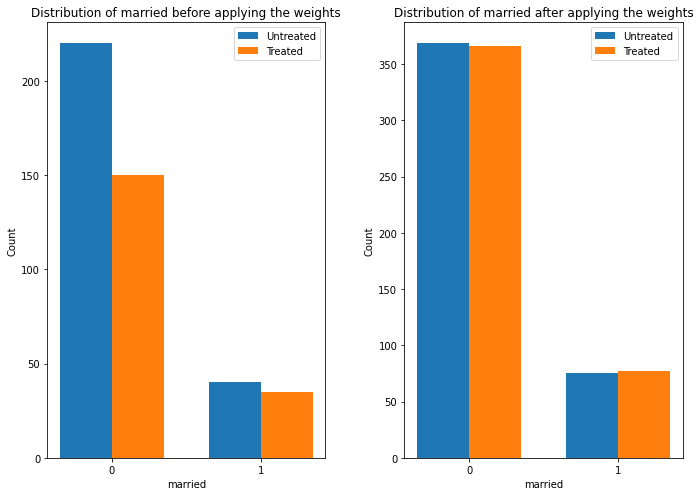

In [4]:
estimate.interpret(method_name="confounder_distribution_interpreter",var_type='discrete',
                   var_name='married', fig_size = (10, 7), font_size = 12)

## Sanity check: compare to manual IPW estimate

In [5]:
df = model._data
ps = df['ps']
y = df['re78']
z = df['treat']

ey1 = z*y/ps / sum(z/ps)
ey0 = (1-z)*y/(1-ps) / sum((1-z)/(1-ps))
ate = ey1.sum()-ey0.sum()
print("Causal Estimate is " + str(ate))

# correct -> Causal Estimate is 1634.9868359746906

Causal Estimate is 1639.8546888423534
